In [123]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(precision=2, suppress=True)

## About data

**Context:** Housing values in Boston suburbs (1978). 506 instances, 14 attributes.

**Source**: Harrison & Rubinfeld (1978). Missing Values: None.

### Key Attributes
* **CRIM**: Per capita crime rate.
* **ZN**: Proportion of residential land for large lots (>25k sq.ft).
* **INDUS**: Proportion of non-retail business acres.
* **CHAS**: Charles River dummy (1 if bounds river; 0 otherwise).
* **NOX**: Nitric oxides concentration (pollution).
* **RM**: Avg. number of rooms per dwelling.
* **AGE**: % of units built prior to 1940.
* **DIS**: Distance to employment centers.
* **RAD**: Accessibility to radial highways.
* **TAX**: Property-tax rate.
* **PTRATIO**: Pupil-teacher ratio.
* **B**: Proportion of population of Black descent (statistically transformed).
* **LSTAT**: % lower status of the population.
* **MEDV (Target)**: Median value of owner-occupied homes ($1000s).

In [125]:
df = pd.read_csv('data/housing.csv')
df.head()
df.shape

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.01,18.00,2.31,0,0.54,6.58,65.20,4.09,1,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0,0.47,6.42,78.90,4.97,2,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0,0.47,7.18,61.10,4.97,2,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0,0.46,7.00,45.80,6.06,3,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0,0.46,7.15,54.20,6.06,3,222.00,18.70,396.90,5.33,36.20


(506, 14)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [127]:
df.describe().loc[["min", "max", "mean"]]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53


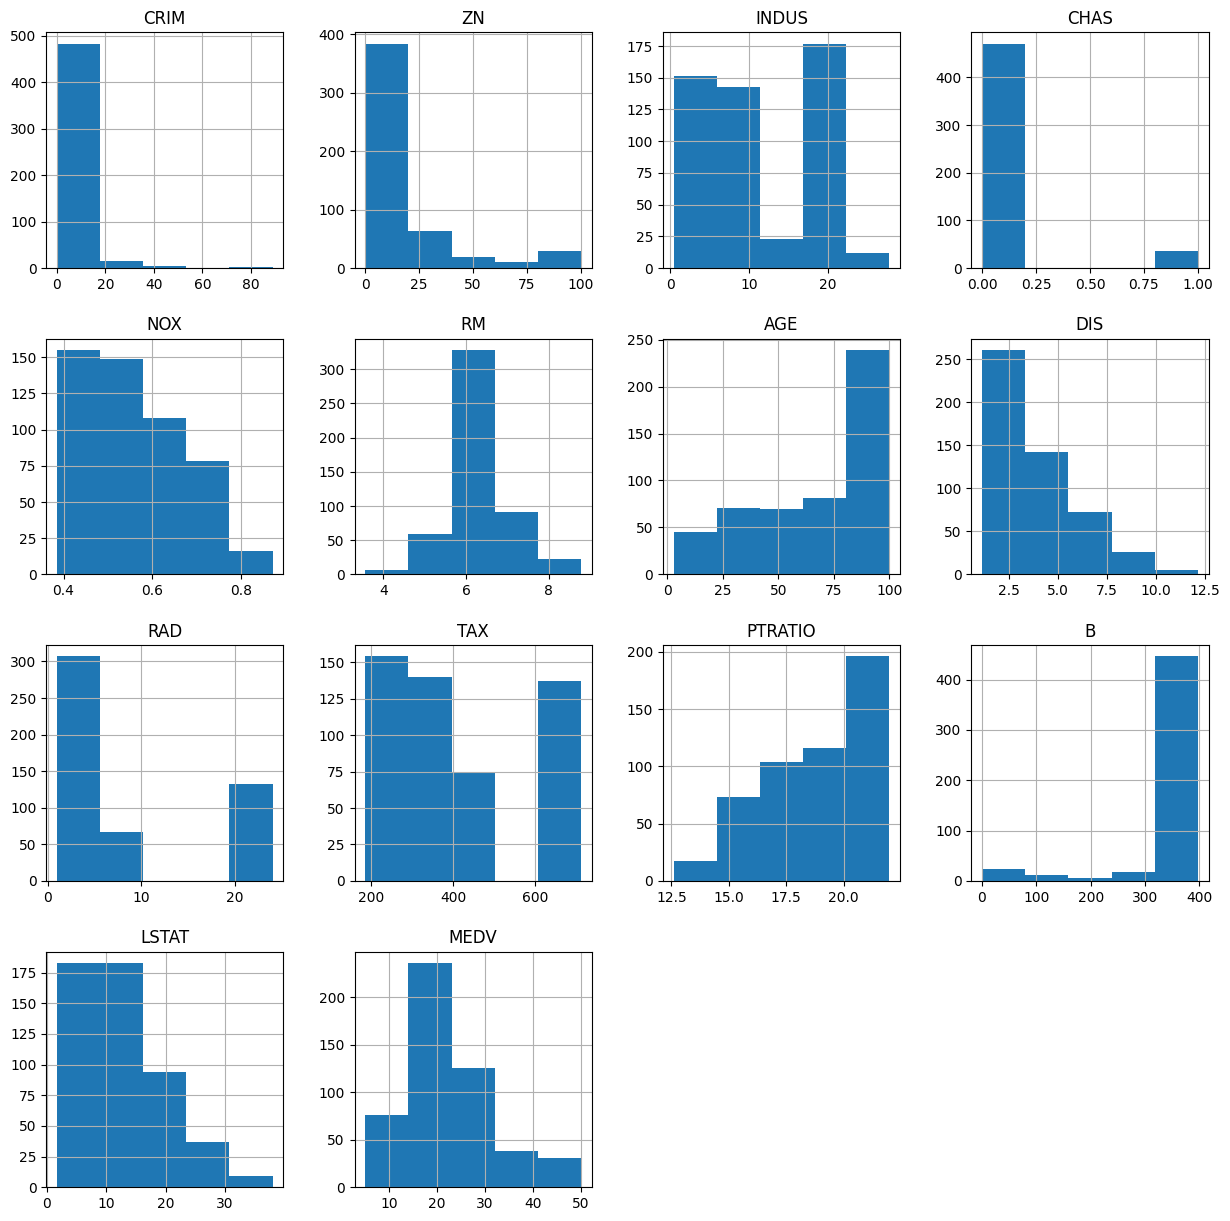

In [128]:
_ = df.hist(bins=5, figsize=(15, 15))

## Train test split

- Split the whole data into 2 parts:
  1. Training set: used to train the model (80%)
  2. Testing set: used to do test the model (20%)

### Manual splitting logic

In [129]:
def split_train_test(df, test_ratio=0.2, random_state=42):
  np.random.seed(random_state)
  shuffled = np.random.permutation(len(df))

  test_size = math.ceil(len(df) * test_ratio)

  test_indices = shuffled[:test_size]
  train_indices = shuffled[test_size:]

  test_set = df.iloc[test_indices]
  train_set = df.iloc[train_indices]

  return train_set, test_set


train_set, test_set = split_train_test(df, test_ratio=0.2, random_state=42)

train_set.shape
test_set.shape

(404, 14)

(102, 14)

## Using sklearn `train_test_split` from sklearn

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_set.shape
test_set.shape

(404, 14)

(102, 14)

### Stratified sampling
Make sure training and testing sets, both have good diversity

e.g. Suppose 100 students (85 boys, 15 girls)

Below is a **bad splitting**


- Train set: 80 students (77 boys, 3 girls) <- not enough girls
- Test set: 20 students (8 boys, 12 girls) <- not enough boys

In [132]:
def compare_proportions(df, train, test, col):
  # Calculate percentages
  overall = df[col].value_counts(normalize=True).sort_index()
  train_dist = train[col].value_counts(normalize=True).sort_index()
  test_dist = test[col].value_counts(normalize=True).sort_index()

  # Combine into a single dataframe for easy comparison
  comparison = pd.DataFrame({
      'Overall %': overall,
      'Train %': train_dist,
      'Test %': test_dist
  })

  # Fill NaN as 0 in case of any missing data in any set
  comparison = comparison.fillna(0)

  # Display as percentage string
  print(comparison.map(lambda x: f"{x:.1%}"))

Observe the values and their frequencies

In [133]:
df['CHAS'].value_counts()
df['RAD'].value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

RAD
24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: count, dtype: int64

Observe the unequal proportions of values in train and test sets

In [134]:
compare_proportions(df, train_set, test_set, 'CHAS')

     Overall % Train % Test %
CHAS                         
0        93.1%   92.8%  94.1%
1         6.9%    7.2%   5.9%


In [135]:
compare_proportions(df, train_set, test_set, 'RAD')

    Overall % Train % Test %
RAD                         
1        4.0%    4.2%   2.9%
2        4.7%    5.2%   2.9%
3        7.5%    7.9%   5.9%
4       21.7%   19.8%  29.4%
5       22.7%   23.3%  20.6%
6        5.1%    5.7%   2.9%
7        3.4%    3.7%   2.0%
8        4.7%    5.2%   2.9%
24      26.1%   25.0%  30.4%


Stratified split can technically be applied on single column

Stratified split should be applied on the column which has more effect due to disproportionate distribution of values in train and test set

Here we choose `RAD`

In [136]:
from sklearn.model_selection import StratifiedShuffleSplit

In [137]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices, test_indices in split.split(df, df['RAD']):
  strat_train_set = df.iloc[train_indices]
  strat_test_set = df.iloc[test_indices]

strat_train_set.shape
strat_test_set.shape

(404, 14)

(102, 14)

In [138]:
compare_proportions(df, strat_train_set, strat_test_set, 'RAD')

    Overall % Train % Test %
RAD                         
1        4.0%    4.0%   3.9%
2        4.7%    4.7%   4.9%
3        7.5%    7.4%   7.8%
4       21.7%   21.8%  21.6%
5       22.7%   22.8%  22.5%
6        5.1%    5.2%   4.9%
7        3.4%    3.5%   2.9%
8        4.7%    4.7%   4.9%
24      26.1%   26.0%  26.5%


### EDA - Exploratory Data Analysis
Looking into correlations

In [139]:
# EDA is only done on train set
# We are not going to touch test set
housing = strat_train_set.copy()

In [140]:
corr = housing.corr().abs()

# To avoid duplicate pairs((A,B) and (B,A)), mask the upper triangle
# Also remove self correlation, (on the diagonal where, corr=1)
mask1 = np.triu(np.ones(corr.shape), k=1).astype(bool)
mask2 = corr >= 0.6

corr.where(mask1 & mask2).fillna('-')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,-,-,-,-,-,-,-,-,0.67,0.62,-,-,-,-
ZN,-,-,-,-,-,-,-,0.67,-,-,-,-,-,-
INDUS,-,-,-,-,0.75,-,0.64,0.70,-,0.70,-,-,0.63,-
CHAS,-,-,-,-,-,-,-,-,-,-,-,-,-,-
NOX,-,-,-,-,-,-,0.73,0.76,-,0.65,-,-,0.61,-
RM,-,-,-,-,-,-,-,-,-,-,-,-,0.63,0.74
AGE,-,-,-,-,-,-,-,0.74,-,-,-,-,0.61,-
DIS,-,-,-,-,-,-,-,-,-,-,-,-,-,-
RAD,-,-,-,-,-,-,-,-,-,0.90,-,-,-,-
TAX,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [141]:
high_corr_pairs = list(corr.where(mask1 & mask2).stack().sort_values(ascending=False).index)
len(high_corr_pairs)
high_corr_pairs[:5]

18

[('RAD', 'TAX'),
 ('NOX', 'DIS'),
 ('INDUS', 'NOX'),
 ('LSTAT', 'MEDV'),
 ('AGE', 'DIS')]

Now we would create scatter plot for each pair

A single plot contains many subplots

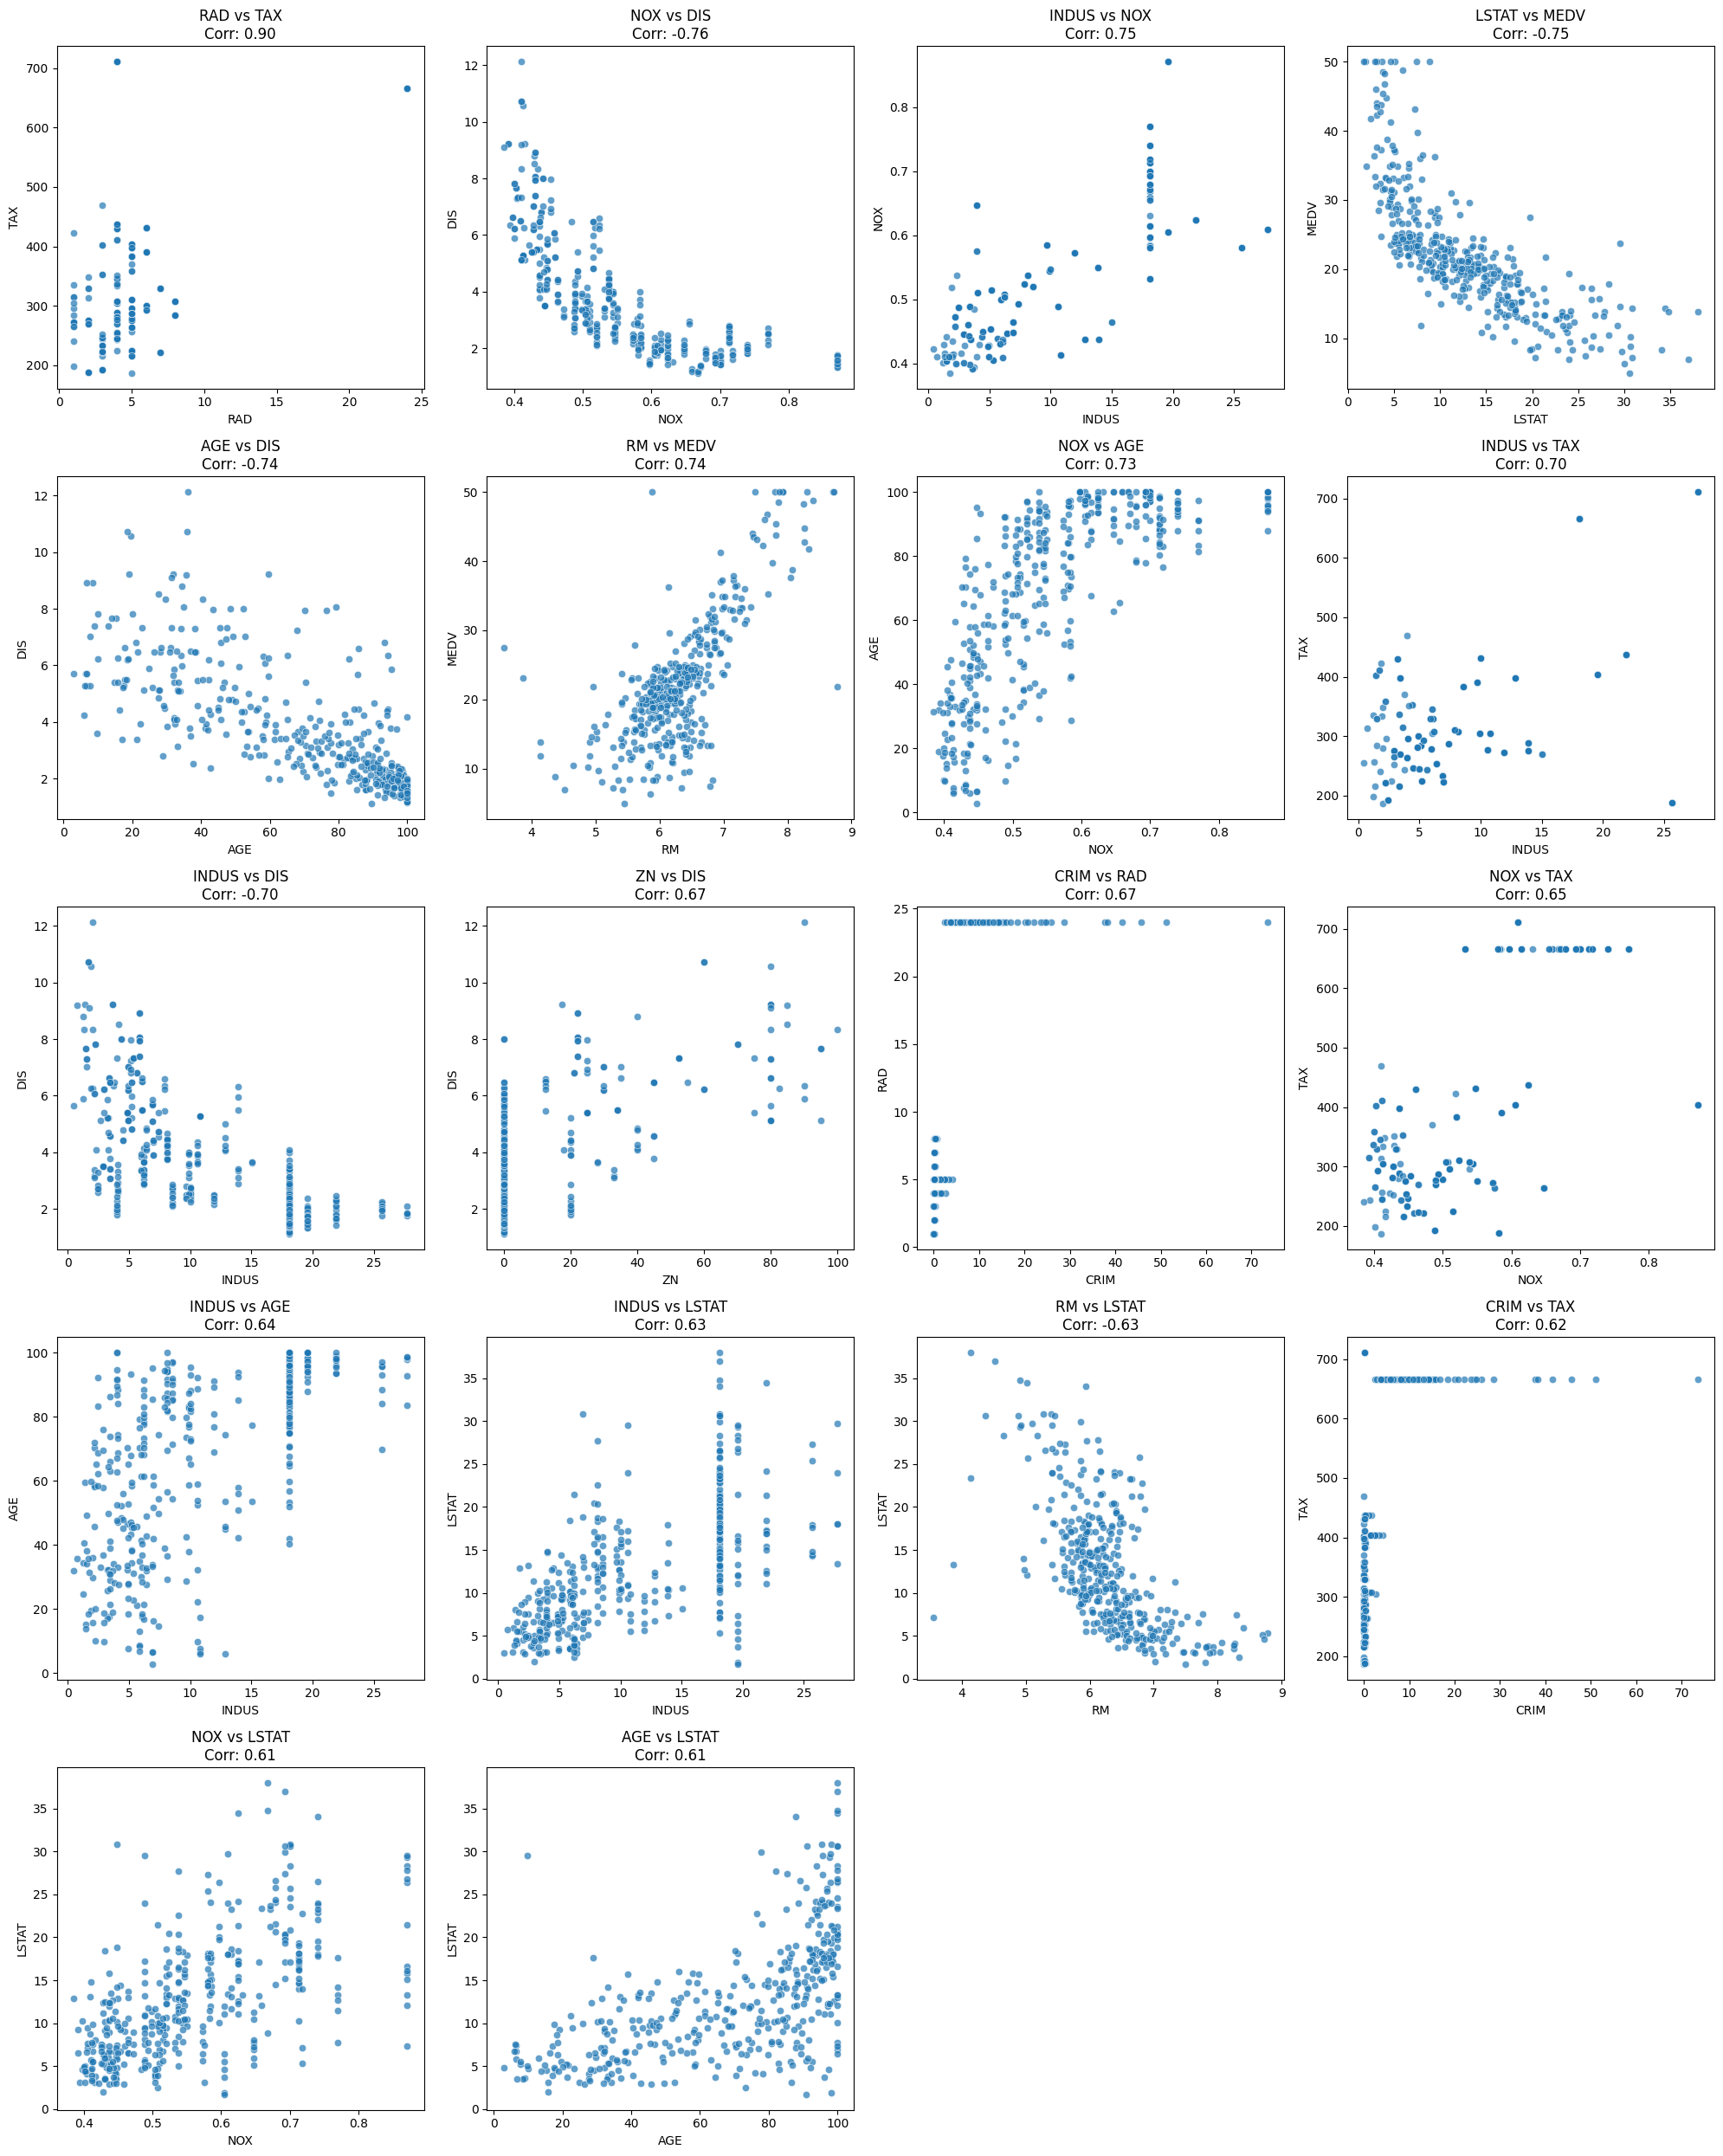

In [142]:
# Calculate grid dimensions of plot
n_plots = len(high_corr_pairs)
n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

# Create the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()  # Flatten to iterate easily

# Iterate to create scatter plot for each pair
for i, (col_x, col_y) in enumerate(high_corr_pairs):
  _ = sns.scatterplot(data=housing, x=col_x, y=col_y, ax=axes[i], alpha=0.7)
  correlation = housing[col_x].corr(housing[col_y])
  _ = axes[i].set_title(f'{col_x} vs {col_y}\nCorr: {correlation:.2f}')

# Delete empty subplots (if any)
for j in range(i+1, len(axes)):
  _ = fig.delaxes(axes[j])

plt.tight_layout()

np.float64(-0.7485009510441145)

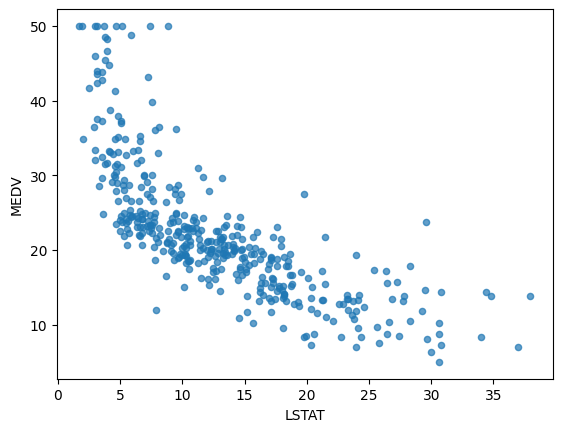

In [143]:
_ = housing.plot(kind='scatter', x='LSTAT', y='MEDV', alpha=0.7)

housing['LSTAT'].corr(housing['MEDV'])

## Trying attribute combinations

Making new columns from existing columns

When 2 columns are related, it is useful to combine them to form a new column

During regression it makes the prediction better 

In [144]:
# Just for demonstration
housing['MEDV'].corr(housing['TAX'])
housing['MEDV'].corr(housing['RM'])
housing['MEDV'].corr(housing['TAX']/housing['RM'])  # not going to use in our train set

np.float64(-0.5094647279086685)

np.float64(0.7394516416728183)

np.float64(-0.5807950477688402)

## Preprocessing
### Splitting features and label

`X` - The feature matrix (All columns except target)

`y` - The label or target (What we are trying to predict)

In [145]:
X_train = strat_train_set.iloc[:, :-1]
y_train = strat_train_set.iloc[:, -1]

X_test = strat_test_set.iloc[:, :-1]
y_test = strat_test_set.iloc[:, -1]

X_train.shape
y_train.shape

X_test.shape
y_test.shape

(404, 13)

(404,)

(102, 13)

(102,)

## Imputation: filling missing values
⚠️ Imputation and scaling can be done without pipeline but it is better to use pipeline

**Our chosen data doesn't have any null values**

Imputation is not needed in our case but we will do it for demonstration

⚠️ Rules for imputation (also applies for scaling):
  1. Only apply imputation on features NEVER on labels
      - If there are missing values in labels then we must drop it

  2. Fit ONLY ON train set, transform train and test set using same imputer/scalar/pipeline

In [146]:
X_train.isnull().sum().sum()  # Total nulls across all features of train set
X_test.isnull().sum().sum()  # Total nulls across all features of test set

np.int64(0)

np.int64(0)

In [147]:
X_missing = X_train.copy()
X_missing.loc[X_missing.sample(10).index, ['RM']] = pd.NA
X_missing.loc[X_missing.sample(10).index, ['TAX']] = pd.NA
X_missing.isnull().sum()

CRIM        0
ZN          0
INDUS       0
CHAS        0
NOX         0
RM         10
AGE         0
DIS         0
RAD         0
TAX        10
PTRATIO     0
B           0
LSTAT       0
dtype: int64

### Drop the columns having missing values

In [148]:
X_missing.drop(columns=['RM', 'TAX']).shape

(404, 11)

### Drop the rows having missing values

In [149]:
X_missing.dropna().shape
X_missing.dropna(subset=['TAX']).shape

(384, 13)

(394, 13)

### Fill the missing values with mean/median/mode values of respective columns
- Careful while using mode because it has many values

In [150]:
X_missing['TAX'].fillna(X_missing['TAX'].mean()).isnull().sum()
X_missing['RM'].fillna(X_missing['RM'].median()).isnull().sum()

np.int64(0)

np.int64(0)

## Using `SimpleImputer` from sklearn
- `fit()` - Algo will learn from data

- `transform()` - Algo will transform the data based on learning

⚠️ Always use train set to fit but transform the test set using same fitted algo

In [151]:
from sklearn.impute import SimpleImputer

In [152]:
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

SimpleImputer(strategy='median')

In [153]:
X_train.median().values  # directly seeing median of each col
imputer.statistics_  # median value learned by imputer

array([  0.23,   0.  ,   9.69,   0.  ,   0.54,   6.21,  77.7 ,   3.12,
         5.  , 332.  ,  19.1 , 390.94,  11.43])

array([  0.23,   0.  ,   9.69,   0.  ,   0.54,   6.21,  77.7 ,   3.12,
         5.  , 332.  ,  19.1 , 390.94,  11.43])

In [154]:
X_imputed = imputer.transform(X_train)
X_imputed  # numpy arr

array([[  0.08,   0.  ,   4.05, ...,  16.6 , 393.23,   9.64],
       [  0.07,   0.  ,  25.65, ...,  19.1 , 377.67,  14.27],
       [  8.72,   0.  ,  18.1 , ...,  20.2 , 391.98,  17.12],
       ...,
       [  1.61,   0.  ,   8.14, ...,  21.  , 248.31,  20.34],
       [  0.12,  12.5 ,   7.87, ...,  15.2 , 396.9 ,  13.27],
       [  0.15,   0.  ,  25.65, ...,  19.1 , 370.31,  25.41]])

In [155]:
X_imputed = pd.DataFrame(imputer.transform(
    X_train), columns=X_train.columns)  # converted to dataframe
X_imputed.shape
X_imputed.isnull().sum().sum()  # Do we still have null values?

(404, 13)

np.int64(0)

### Feature scaling

Scaling strategies:
  1. Min-max scaling - Values are from 0 to 1
  2. Standard scaling - Values are such that mean = 0, SD = 1

In [156]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [157]:
scalar = StandardScaler()
scalar.fit(X_train)

x_train_scaled = pd.DataFrame(scalar.transform(X_train), columns=X_train.columns)
x_train_scaled.describe().loc[["mean", "max", "min"]]

StandardScaler()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
mean,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00
max,9.34,3.83,2.38,3.74,2.70,3.49,1.12,4.00,1.67,1.79,1.63,0.45,3.50
min,-0.45,-0.49,-1.55,-0.27,-1.46,-3.80,-2.31,-1.26,-0.98,-1.32,-2.74,-3.77,-1.52


In [158]:
scalar = MinMaxScaler()
scalar.fit(X_train)

X_train_scaled = pd.DataFrame(scalar.transform(X_train), columns=X_train.columns)
X_train_scaled.describe().loc[['min', 'max']]

MinMaxScaler()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Preprocessing pipeline

In [159]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy='median')),
    ('StandardScaler', StandardScaler())
])

In [160]:
# Fit only on train set
pipeline.fit(X_train)

X_train_tr = pd.DataFrame(pipeline.transform(X_train), columns=X_train.columns)
X_test_tr = pd.DataFrame(pipeline.transform(X_test), columns=X_test.columns)

X_train_tr.shape
X_test_tr.shape

Pipeline(steps=[('SimpleImputer', SimpleImputer(strategy='median')),
                ('StandardScaler', StandardScaler())])

(404, 13)

(102, 13)

## Model selection

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score

### Cross validation score
⚠️ Entire train set is scaled, Not suitable for cross validation
- Better way is to include model as last step of pipeline, then do `cross_val_score(pipeline,...)`
- Skipping this here for simplicity

In [162]:
def cross_validation(model):
  scores = cross_val_score(model, X_train_tr, y_train, scoring='neg_mean_squared_error', cv=10)
  rmse_scores = np.sqrt(-scores)

  print('Cross validation results:')
  print(f'Mean RMSE = {rmse_scores.mean():.2f}')
  print(f'Std RMSE = {rmse_scores.std():.2f}')

 ⚠️ For demo purposes, we are directly using the test set for evaluation here.
 
 But the standard way is to use the test set ONLY IN THE LAST when you have selected a model based on cross validation.

In [163]:
model = LinearRegression()
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

cross_validation(model)  # Cross validation on already seen data (train)
root_mean_squared_error(y_test, y_pred)

LinearRegression()

Cross validation results:
Mean RMSE = 4.43
Std RMSE = 0.57


6.549992419890326

In [164]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test_tr)

cross_validation(model)
root_mean_squared_error(y_test, y_pred)

DecisionTreeRegressor()

Cross validation results:
Mean RMSE = 3.88
Std RMSE = 0.75


27.11370574480158

In [165]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test_tr)

cross_validation(model)
root_mean_squared_error(y_test, y_pred)

RandomForestRegressor()

Cross validation results:
Mean RMSE = 3.23
Std RMSE = 0.82


14.770464614939382